In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [6]:
def calc_ow(uu, vv, dx, dy):
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std

def calc_lnam(x, y, uu, vv):
    f = -1
    dx, dy = np.zeros_like(x), np.zeros_like(x)
    dux, duy, dvx, dvy = np.zeros_like(x), np.zeros_like(x), np.zeros_like(x), np.zeros_like(x)
    dx[1:-1, 1:-1] = x[1:-1, 2:] - x[1:-1, :-2]
    dy[1:-1, 1:-1] = y[2:, 1:-1] - y[:-2, 1:-1]
    dux[1:-1, 1:-1] = uu[1:-1, 2:] - uu[1:-1, :-2]
    duy[1:-1, 1:-1] = uu[2:, 1:-1] - uu[:-2, 1:-1]
    dvx[1:-1, 1:-1] = vv[1:-1, 2:] - vv[1:-1, :-2]
    dvy[1:-1, 1:-1] = vv[2:, 1:-1] - vv[:-2, 1:-1]
    epsilon = 1e-10  # A small number to prevent division by zero
    sn = np.divide((dux / (dx + epsilon)) - (dvy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    ss = np.divide((dvx / (dx + epsilon)) + (duy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    om = np.divide((dvx / (dx + epsilon)) - (duy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    # div = np.divide((dux / (dx + epsilon)) + (dvy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    okubo = sn**2 + ss**2 - om**2  # in s^-2
    
    # Initialization
    LNAM, LOW = np.full_like(uu, np.nan), np.full_like(uu, np.nan)
    b = np.ones_like(x, dtype=int) # 2b is the side length of the local box
    borders = np.max(b) + 1
    
    # Loop through domain to calculate LNAM and LOW
    for i in range(borders, len(vv[:, 0]) - borders + 1):
        for j in range(borders, len(vv[0, :]) - borders + 1):
            if not np.isnan(vv[i, j]):
                OW = okubo[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                LOW[i, j] = np.nanmean(OW)
                
                xlocal = x[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                ylocal = y[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                ulocal = uu[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                vlocal = vv[i - b[i, j]:i + b[i, j] + 1, j - b[i, j] + 1]
                
                coordcentre = (xlocal.shape[0] - 1) // 2
                d_xcentre = (xlocal - xlocal[coordcentre, coordcentre])
                d_ycentre = (ylocal - ylocal[coordcentre, coordcentre])
                
                cross = (d_xcentre * vlocal) - (d_ycentre * ulocal)
                dot = (ulocal * d_xcentre) + (vlocal * d_ycentre)
                produit = np.sqrt(ulocal**2 + vlocal**2) * np.sqrt(d_xcentre**2 + d_ycentre**2)
                sumdp = np.sum(dot) + np.sum(produit)
                
                LNAM[i, j] = np.sum(cross) / sumdp * np.sign(f) if sumdp != 0 else 0
    
    return LNAM, LOW

In [35]:
def calculate_eddy(width=500000, num_depth_layers=30, eta0=1, L=1e5, H=1000, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0.01, alpha_2=0.01, T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, temperature, salinity, 
    and pressure fields for an ocean eddy.

    Parameters:
    - width: Horizontal extent of the grid (eddy scale) in meters.
    - num_depth_layers: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a, b: Coefficients affecting density anomaly variation.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -34 degrees.
    - alpha_1, alpha_2: Coefficients affecting eddy center shift with depth.
    - T0: Surface temperature (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    - dSdz: Salinity gradient with depth (psu per meter).
    - taper_depth: Tapering scale for vertical variations.

    Returns:
    - U, V: 3D matrices for the U and V (x- and y-components) velocity fields.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - S: 3D matrix for the salinity field.
    - P: 3D matrix for the pressure field.
    - x, y, z: Horizontal and vertical grid points.
    """

    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))  # Coriolis parameter for latitude -34 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)

    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-width // 2, width // 2, 100)  # x-coordinates
    y = np.linspace(-width // 2, width // 2, 100)  # y-coordinates
    z = np.linspace(-H, 0, num_depth_layers)  # Depth levels from surface (0) to -H

    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

    if taper_depth is None:
        taper_factor = 1
    else:
        taper_factor = np.exp(z_3d / taper_depth)

    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)

    def g_z(z, H, taper_factor):
        return np.exp(z / H) * taper_factor if taper_depth else 1

    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d

    # Calculate radial distance r - r_c(z)
    r_c = np.sqrt((x_3d - x_c)**2 + (y_3d - y_c)**2)

    # Temperature field
    # T = T0 + dTdz * z_3d - 2 * f_r_rc(r_c, L) * taper_factor
    T = - 2 * f_r_rc(r_c, L) * taper_factor

    # Salinity field
    S0 = 35  # Reference surface salinity (psu)
    # S = S0 + dSdz * z_3d + 1.5 * f_r_rc(r_c, L) * taper_factor
    S = 1.5 * f_r_rc(r_c, L) * taper_factor

    # Pressure field (hydrostatic pressure)
    P = -rho0 * g * z_3d

    # Density field using a simplified equation of state
    alpha = 0.0002  # Thermal expansion coefficient (1/°C)
    beta = 0.0008  # Haline contraction coefficient (1/psu)
    sigma = rho0 * (1 - alpha * (T - T0) + beta * (S - S0)) 
    sigma -= np.mean(sigma)

    # Calculate geostrophic velocity components
    dx = x[1] - x[0]  # Grid spacing in x
    dy = y[1] - y[0]  # Grid spacing in y
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy

    U = g / f0 * d_sigma_dy * taper_factor
    V = -g / f0 * d_sigma_dx * taper_factor

    return U, V, sigma, T, S, P, x / 1000, y / 1000, z


## No-Tilt No-Taper

In [ ]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None)

DEPTH_LVL = 25

fields = {
    "T ": (T, "coolwarm", -2, 0),
    "S": (S, "viridis", 0, 1.5),
    r"$\sigma$": (sigma, "plasma", 0, 1.5),
    "CS": (np.hypot(U, V), "cividis", 0, 1.5),
    "OW": (calc_ow(U, V, x[1]-x[0], y[1]-y[0]), "seismic", -0.006, 0),
    "LNAM": (np.zeros_like(U), "inferno", -.1, .3),
}

if "LNAM" in fields:
    X, Y = np.meshgrid(x, y)
    for k in range(U.shape[-1]):
        fields["LNAM"][0][:, :, k], _ = calc_lnam(X, Y, U[:, :, k], V[:, :, k])

fig, axs = plt.subplots(6, 3, figsize=(10, 16))
for r, (field_name, (Field, cmap, vmin, vmax)) in enumerate(fields.items()):
    # Top-down slice
    pcm = axs[r, 0].pcolor(x, y, Field[:, :, DEPTH_LVL].T, cmap=cmap, vmin=vmin, vmax=vmax)
    pcm.set_array(Field[:, :, DEPTH_LVL].T)
    axs[r, 0].set_xlabel('x (km)')
    axs[r, 0].set_ylabel('y (km)')
    cbar = fig.colorbar(pcm, ax=axs[r, 0], orientation='horizontal', location='top')
    cbar.ax.tick_params(axis='x', rotation=45)
    cbar.set_label(field_name)

    # Cross-section at middle y
    pcm = axs[r, 1].pcolor(x, z, Field[:, Field.shape[1] // 2, :].T, cmap=cmap, vmin=vmin, vmax=vmax)
    pcm.set_array(Field[:, Field.shape[1] // 2, :].T)
    axs[r, 1].set_xlabel('x (km)')
    axs[r, 1].set_ylabel('Depth (m)')
    cbar = fig.colorbar(pcm, ax=axs[r, 1], orientation='horizontal', location='top')
    cbar.ax.tick_params(axis='x', rotation=45)
    cbar.set_label(field_name)

    # Cross-section at middle x
    pcm = axs[r, 2].pcolor(y, z, Field[Field.shape[0] // 2, :, :].T, cmap=cmap, vmin=vmin, vmax=vmax)
    pcm.set_array(Field[Field.shape[0] // 2, :, :].T)
    axs[r, 2].set_xlabel('y (km)')
    axs[r, 2].set_ylabel('Depth (m)')
    cbar = fig.colorbar(pcm, ax=axs[r, 2], orientation='horizontal', location='top')
    cbar.ax.tick_params(axis='x', rotation=45)
    cbar.set_label(field_name)

plt.tight_layout()
plt.show()


## Non-Tilt Tapered

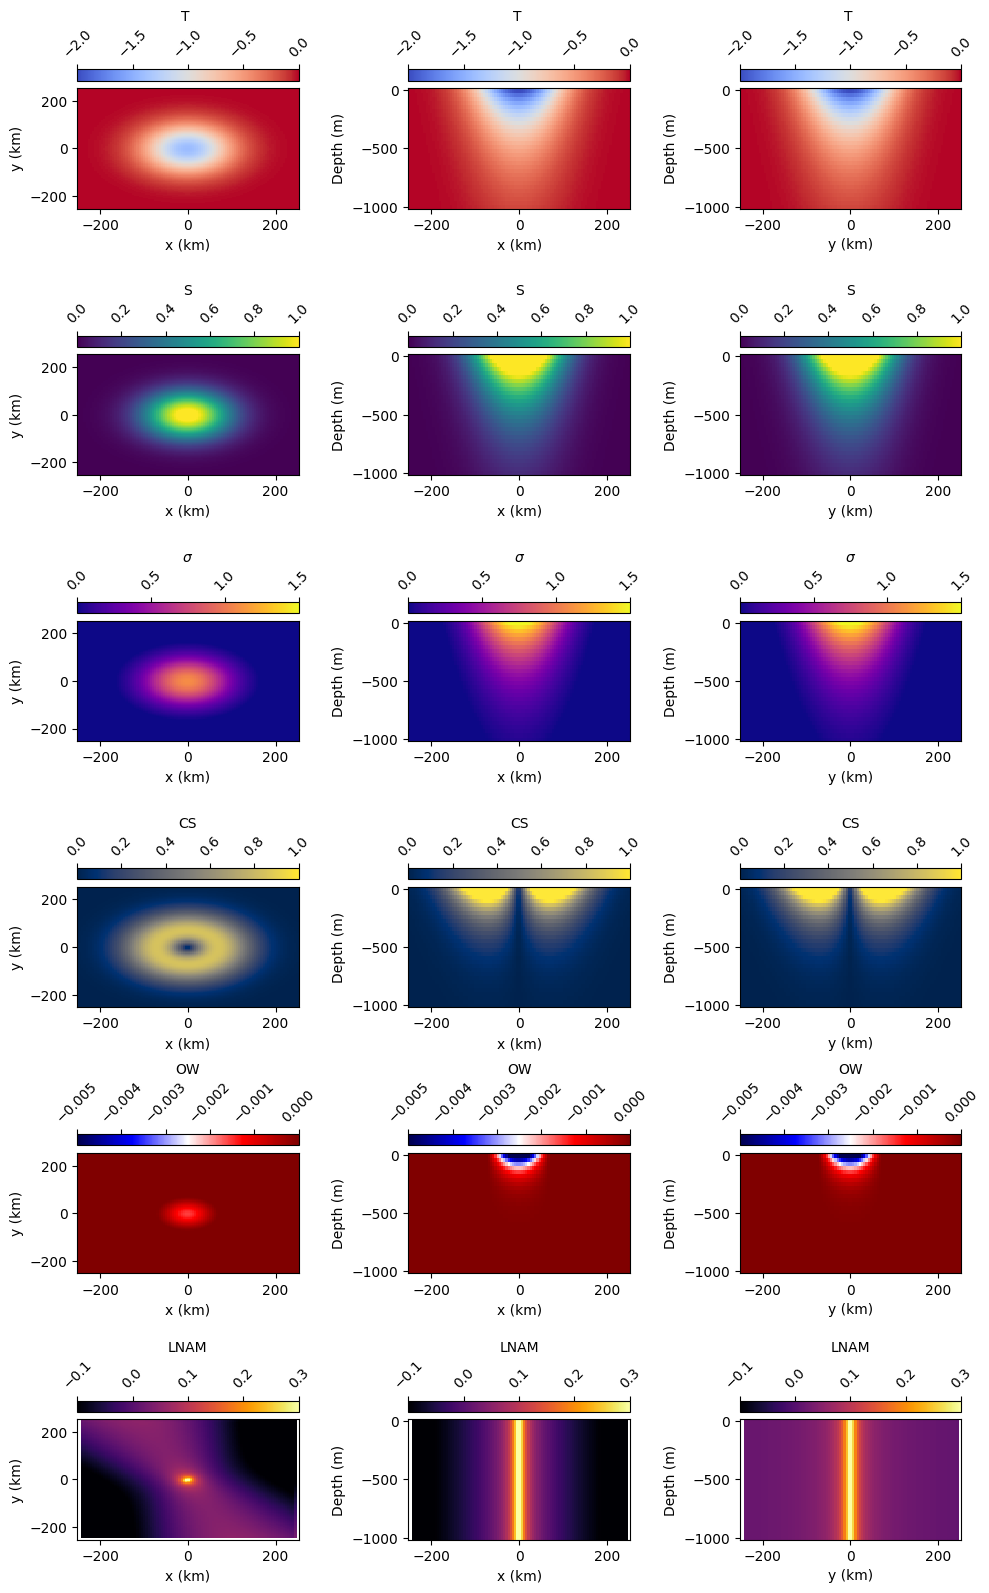

In [54]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=400)

DEPTH_LVL = 25

fields = {
    "T ": (T, "coolwarm", -2, 0),
    "S": (S, "viridis", 0, 1),
    r"$\sigma$": (sigma, "plasma", 0, 1.5),
    "CS": (np.hypot(U, V), "cividis", 0, 1),
    "OW": (calc_ow(U, V, x[1]-x[0], y[1]-y[0]), "seismic", -0.005, 0),
    "LNAM": (np.zeros_like(U), "inferno", -.1, .3),
}

if "LNAM" in fields:
    X, Y = np.meshgrid(x, y)
    for k in range(U.shape[-1]):
        fields["LNAM"][0][:, :, k], _ = calc_lnam(X, Y, U[:, :, k], V[:, :, k])

fig, axs = plt.subplots(6, 3, figsize=(10, 16))
for r, (field_name, (Field, cmap, vmin, vmax)) in enumerate(fields.items()):
    # Top-down slice
    pcm = axs[r, 0].pcolor(x, y, Field[:, :, DEPTH_LVL].T, cmap=cmap, vmin=vmin, vmax=vmax)
    pcm.set_array(Field[:, :, DEPTH_LVL].T)
    axs[r, 0].set_xlabel('x (km)')
    axs[r, 0].set_ylabel('y (km)')
    cbar = fig.colorbar(pcm, ax=axs[r, 0], orientation='horizontal', location='top')
    cbar.ax.tick_params(axis='x', rotation=45)
    cbar.set_label(field_name)

    # Cross-section at middle y
    pcm = axs[r, 1].pcolor(x, z, Field[:, Field.shape[1] // 2, :].T, cmap=cmap, vmin=vmin, vmax=vmax)
    pcm.set_array(Field[:, Field.shape[1] // 2, :].T)
    axs[r, 1].set_xlabel('x (km)')
    axs[r, 1].set_ylabel('Depth (m)')
    cbar = fig.colorbar(pcm, ax=axs[r, 1], orientation='horizontal', location='top')
    cbar.ax.tick_params(axis='x', rotation=45)
    cbar.set_label(field_name)

    # Cross-section at middle x
    pcm = axs[r, 2].pcolor(y, z, Field[Field.shape[0] // 2, :, :].T, cmap=cmap, vmin=vmin, vmax=vmax)
    pcm.set_array(Field[Field.shape[0] // 2, :, :].T)
    axs[r, 2].set_xlabel('y (km)')
    axs[r, 2].set_ylabel('Depth (m)')
    cbar = fig.colorbar(pcm, ax=axs[r, 2], orientation='horizontal', location='top')
    cbar.ax.tick_params(axis='x', rotation=45)
    cbar.set_label(field_name)

plt.tight_layout()
plt.show()


## Tilt No-Taper

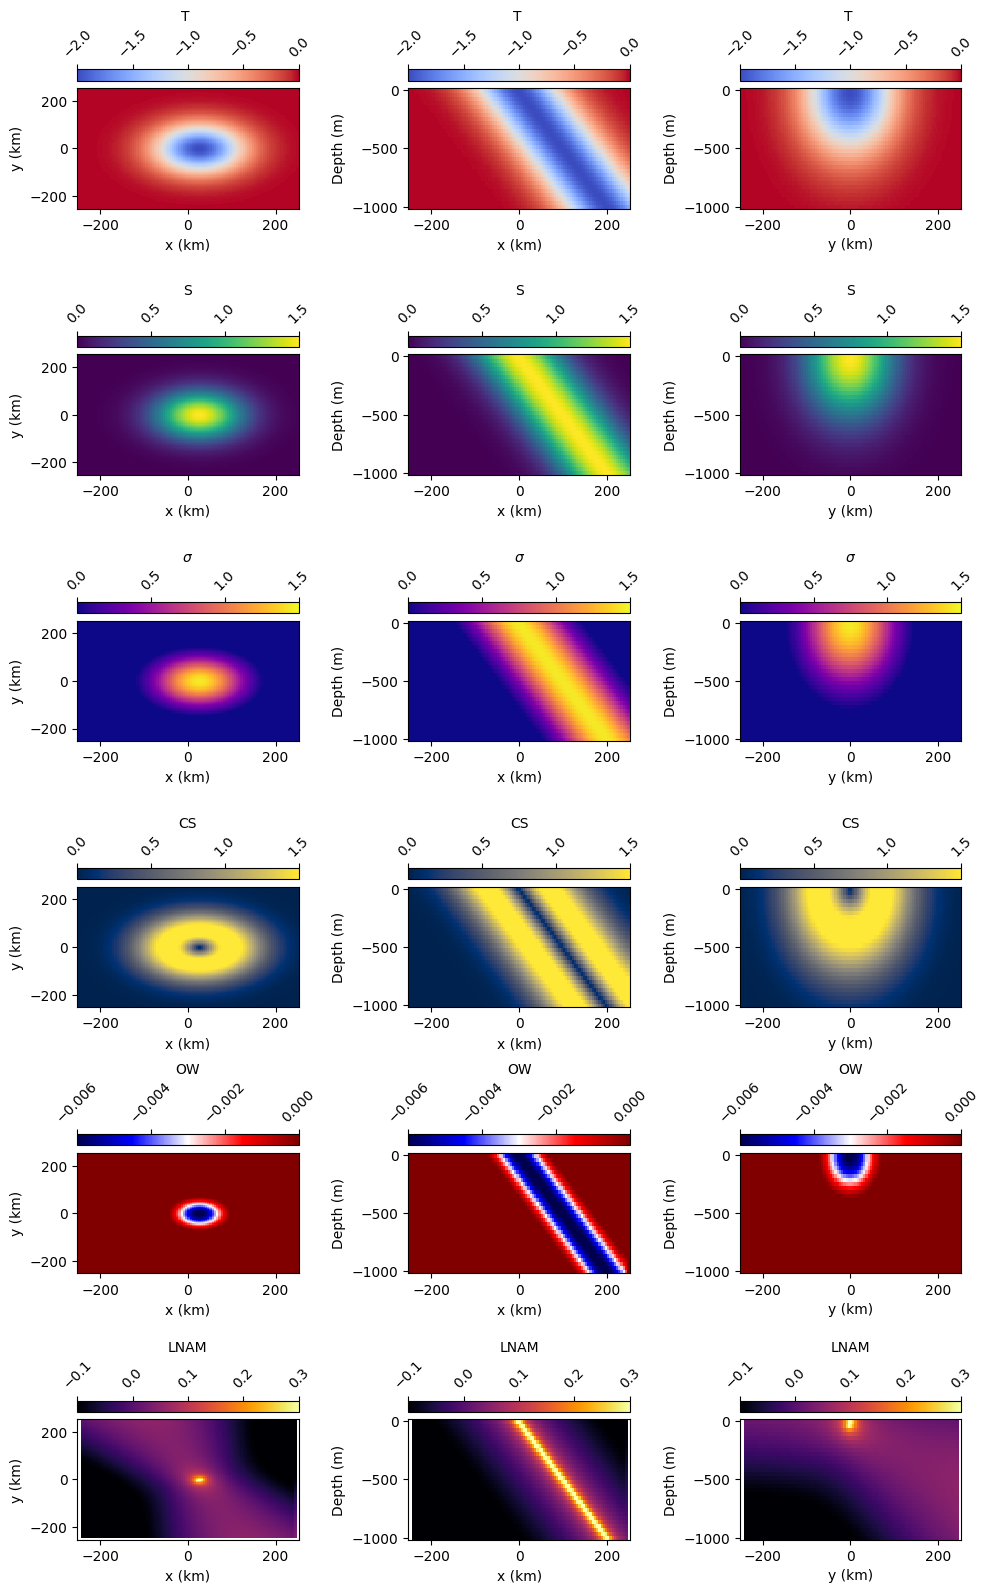

In [55]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None, alpha_1=-200)

DEPTH_LVL = 25

fields = {
    "T ": (T, "coolwarm", -2, 0),
    "S": (S, "viridis", 0, 1.5),
    r"$\sigma$": (sigma, "plasma", 0, 1.5),
    "CS": (np.hypot(U, V), "cividis", 0, 1.5),
    "OW": (calc_ow(U, V, x[1]-x[0], y[1]-y[0]), "seismic", -0.006, 0),
    "LNAM": (np.zeros_like(U), "inferno", -.1, .3),
}

if "LNAM" in fields:
    X, Y = np.meshgrid(x, y)
    for k in range(U.shape[-1]):
        fields["LNAM"][0][:, :, k], _ = calc_lnam(X, Y, U[:, :, k], V[:, :, k])

fig, axs = plt.subplots(6, 3, figsize=(10, 16))
for r, (field_name, (Field, cmap, vmin, vmax)) in enumerate(fields.items()):
    # Top-down slice
    pcm = axs[r, 0].pcolor(x, y, Field[:, :, DEPTH_LVL].T, cmap=cmap, vmin=vmin, vmax=vmax)
    pcm.set_array(Field[:, :, DEPTH_LVL].T)
    axs[r, 0].set_xlabel('x (km)')
    axs[r, 0].set_ylabel('y (km)')
    cbar = fig.colorbar(pcm, ax=axs[r, 0], orientation='horizontal', location='top')
    cbar.ax.tick_params(axis='x', rotation=45)
    cbar.set_label(field_name)

    # Cross-section at middle y
    pcm = axs[r, 1].pcolor(x, z, Field[:, Field.shape[1] // 2, :].T, cmap=cmap, vmin=vmin, vmax=vmax)
    pcm.set_array(Field[:, Field.shape[1] // 2, :].T)
    axs[r, 1].set_xlabel('x (km)')
    axs[r, 1].set_ylabel('Depth (m)')
    cbar = fig.colorbar(pcm, ax=axs[r, 1], orientation='horizontal', location='top')
    cbar.ax.tick_params(axis='x', rotation=45)
    cbar.set_label(field_name)

    # Cross-section at middle x
    pcm = axs[r, 2].pcolor(y, z, Field[Field.shape[0] // 2, :, :].T, cmap=cmap, vmin=vmin, vmax=vmax)
    pcm.set_array(Field[Field.shape[0] // 2, :, :].T)
    axs[r, 2].set_xlabel('y (km)')
    axs[r, 2].set_ylabel('Depth (m)')
    cbar = fig.colorbar(pcm, ax=axs[r, 2], orientation='horizontal', location='top')
    cbar.ax.tick_params(axis='x', rotation=45)
    cbar.set_label(field_name)

plt.tight_layout()
plt.show()


## Tilt Tapered

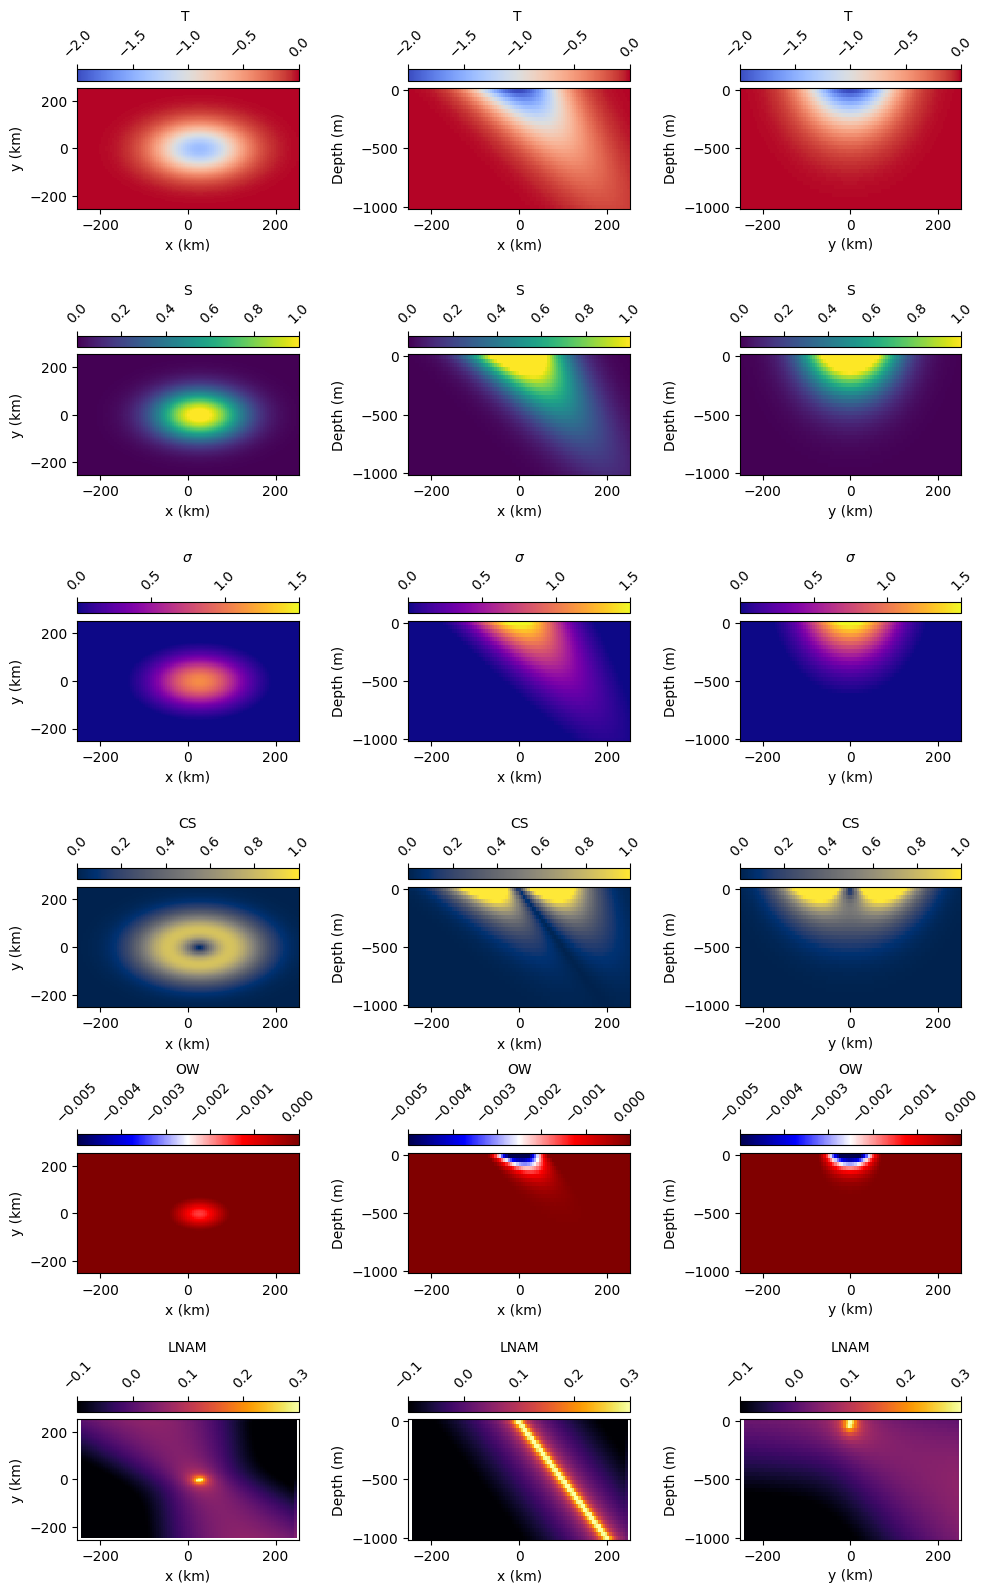

In [56]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=400, alpha_1=-200)

DEPTH_LVL = 25

fields = {
    "T ": (T, "coolwarm", -2, 0),
    "S": (S, "viridis", 0, 1),
    r"$\sigma$": (sigma, "plasma", 0, 1.5),
    "CS": (np.hypot(U, V), "cividis", 0, 1),
    "OW": (calc_ow(U, V, x[1]-x[0], y[1]-y[0]), "seismic", -0.005, 0),
    "LNAM": (np.zeros_like(U), "inferno", -.1, .3),
}

if "LNAM" in fields:
    X, Y = np.meshgrid(x, y)
    for k in range(U.shape[-1]):
        fields["LNAM"][0][:, :, k], _ = calc_lnam(X, Y, U[:, :, k], V[:, :, k])

fig, axs = plt.subplots(6, 3, figsize=(10, 16))
for r, (field_name, (Field, cmap, vmin, vmax)) in enumerate(fields.items()):
    # Top-down slice
    pcm = axs[r, 0].pcolor(x, y, Field[:, :, DEPTH_LVL].T, cmap=cmap, vmin=vmin, vmax=vmax)
    pcm.set_array(Field[:, :, DEPTH_LVL].T)
    axs[r, 0].set_xlabel('x (km)')
    axs[r, 0].set_ylabel('y (km)')
    cbar = fig.colorbar(pcm, ax=axs[r, 0], orientation='horizontal', location='top')
    cbar.ax.tick_params(axis='x', rotation=45)
    cbar.set_label(field_name)

    # Cross-section at middle y
    pcm = axs[r, 1].pcolor(x, z, Field[:, Field.shape[1] // 2, :].T, cmap=cmap, vmin=vmin, vmax=vmax)
    pcm.set_array(Field[:, Field.shape[1] // 2, :].T)
    axs[r, 1].set_xlabel('x (km)')
    axs[r, 1].set_ylabel('Depth (m)')
    cbar = fig.colorbar(pcm, ax=axs[r, 1], orientation='horizontal', location='top')
    cbar.ax.tick_params(axis='x', rotation=45)
    cbar.set_label(field_name)

    # Cross-section at middle x
    pcm = axs[r, 2].pcolor(y, z, Field[Field.shape[0] // 2, :, :].T, cmap=cmap, vmin=vmin, vmax=vmax)
    pcm.set_array(Field[Field.shape[0] // 2, :, :].T)
    axs[r, 2].set_xlabel('y (km)')
    axs[r, 2].set_ylabel('Depth (m)')
    cbar = fig.colorbar(pcm, ax=axs[r, 2], orientation='horizontal', location='top')
    cbar.ax.tick_params(axis='x', rotation=45)
    cbar.set_label(field_name)

plt.tight_layout()
plt.show()

## OW Isosurface

In [ ]:
def calc_ow(uu, vv, dx, dy):
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std

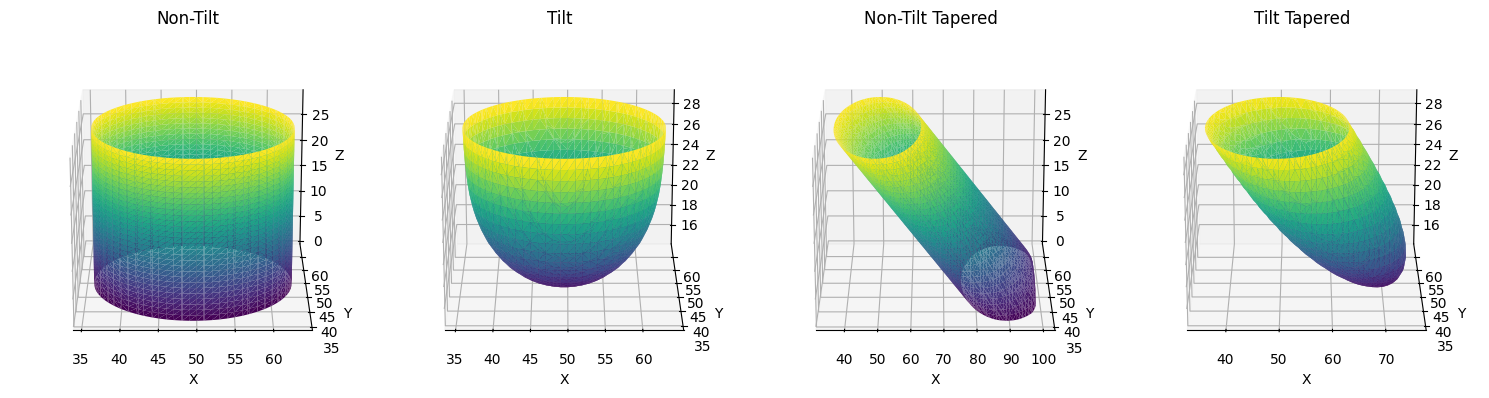

In [61]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize

OW_THRESH = -.2

# no tilt no taper
U, V, _, _, _, _, _, _, _ = calculate_eddy(taper_depth=None)
# no tilt taper
U_tilt, V_tilt, _, _, _, _, _, _, _ = calculate_eddy(taper_depth=400)

U_tap, V_tap, _, _, _, _, _, _, _ = calculate_eddy(taper_depth=None, alpha_1=-200)

U_tilt_tap, V_tilt_tap, _, _, _, _, _, _, _ = calculate_eddy(taper_depth=400, alpha_1=-200)

ow = calc_ow(U, V, x[1]-x[0], y[1]-y[0])
ow = normalize_matrix(ow)

ow_tilt = calc_ow(U_tilt, V_tilt, x[1]-x[0], y[1]-y[0])
ow_tilt = normalize_matrix(ow_tilt)

ow_tap = calc_ow(U_tap, V_tap, x[1]-x[0], y[1]-y[0])
ow_tap = normalize_matrix(ow_tap)

ow_tilt_tap = calc_ow(U_tilt_tap, V_tilt_tap, x[1]-x[0], y[1]-y[0])
ow_tilt_tap = normalize_matrix(ow_tilt_tap)

fig = plt.figure(figsize=(15, 9))

# Non-Tilt Isosurface
ax1 = fig.add_subplot(141, projection='3d')
verts, faces, _, _ = measure.marching_cubes(ow, OW_THRESH)
ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, cmap='viridis', lw=1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Non-Tilt')
ax1.view_init(elev=20, azim=270)

# Tilt Isosurface
ax2 = fig.add_subplot(142, projection='3d')
verts_tilt, faces_tilt, _, _ = measure.marching_cubes(ow_tilt, OW_THRESH)
ax2.plot_trisurf(verts_tilt[:, 0], verts_tilt[:, 1], verts_tilt[:, 2], triangles=faces_tilt, cmap='viridis', lw=1)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Tilt')
ax2.view_init(elev=20, azim=270)

# Non-Tilt Tapered Isosurface
ax3 = fig.add_subplot(143, projection='3d')
verts_tap, faces_tap, _, _ = measure.marching_cubes(ow_tap, OW_THRESH)
ax3.plot_trisurf(verts_tap[:, 0], verts_tap[:, 1], verts_tap[:, 2], triangles=faces_tap, cmap='viridis', lw=1)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.set_title('Non-Tilt Tapered')
ax3.view_init(elev=20, azim=270)

# Tilt Tapered Isosurface
ax4 = fig.add_subplot(144, projection='3d')
verts_tilt_tap, faces_tilt_tap, _, _ = measure.marching_cubes(ow_tilt_tap, OW_THRESH)
ax4.plot_trisurf(verts_tilt_tap[:, 0], verts_tilt_tap[:, 1], verts_tilt_tap[:, 2], triangles=faces_tilt_tap, cmap='viridis', lw=1)
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_zlabel('Z')
ax4.set_title('Tilt Tapered')
ax4.view_init(elev=20, azim=270)

plt.tight_layout()
plt.show()